# Libraries

In [148]:
import os
from datetime import datetime

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.tensorboard import SummaryWriter
from torchvision.ops import box_iou

# Default device

In [149]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu"
torch.set_default_device(device)
device

device(type='cuda')

# Data Analysis and Pre-processing

### 1. Count

In [3]:
img_dir = "honeybee/img"
mask_dir = "honeybee/gt-dots"

images = sorted([f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))])
masks = sorted([f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))])

print("Images: ", len(images))
print("Masks: ", len(masks))

Images:  118
Masks:  128


We can see the imbalace in data, next step would be to pre-process and filter out only unique files

### 2. Naming Style

In [4]:
images[0], masks[0]

('beeType1_008.jpg', 'dots008.png')

We can see the image files' naming style and masks files' naming style, the first word in the image file name just before the underscore must be the all the different classes of bees image present in the dataset and the number following must be the unique identifier for that image file which should correspond to the masks file for that image.

### 3. Filter valid image and mask files

In [5]:
img_files = []
mask_files = []
cls = []
ids = []

for file in images:
    splited_base_name = file.split(".")[0].split("_")
    cls_name, unique_id = splited_base_name[0], splited_base_name[1]

    img_file = f"{img_dir}/{file}"
    mask_file = f"{mask_dir}/dots{unique_id}.png"
    
    if os.path.exists(mask_file):
        img_files.append(img_file)
        mask_files.append(mask_file)
        cls.append(cls_name)
        ids.append(unique_id)

df = pd.DataFrame({"image": img_files, "mask": mask_files, "id": ids, "type": cls})
df["type_label"] = pd.factorize(df["type"])[0] + 1
df.head()

,image,mask,id,type,type_label
0,honeybee/img/beeType1_008.jpg,honeybee/gt-dots/dots008.png,008,beeType1,1
1,honeybee/img/beeType1_009.jpg,honeybee/gt-dots/dots009.png,009,beeType1,1
2,honeybee/img/beeType1_010.jpg,honeybee/gt-dots/dots010.png,010,beeType1,1
3,honeybee/img/beeType1_011.jpg,honeybee/gt-dots/dots011.png,011,beeType1,1
4,honeybee/img/beeType1_012.jpg,honeybee/gt-dots/dots012.png,012,beeType1,1


### 4. Generate bounding boxes and labels

Keeping the dot in mask image as center, we generate 32x32 bounding box coordinates around it. This size was choosen from the observation.

In [6]:
def generate_boxes_from_dots(mask_path, box_size=32):
    mask = cv2.imread(mask_path, 0)
    _, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    num_labels, _, _, centroids = cv2.connectedComponentsWithStats(thresh)

    boxes = []
    h, w = mask.shape
    half = box_size // 2

    # Skip background (label = 0)
    for i in range(1, num_labels):
        cx, cy = centroids[i]
        cx = int(cx)
        cy = int(cy)
        # Compute bounding box coordinates
        x1 = max(0, cx - half)
        y1 = max(0, cy - half)
        x2 = min(w - 1, cx + half)
        y2 = min(h - 1, cy + half)
        boxes.append([x1, y1, x2, y2])
    return boxes

In [7]:
df["bbox"] = df["mask"].apply(generate_boxes_from_dots)
# since we know we only have one class we can directly add label for each bbox
df["bbox_label"] = df["bbox"].apply(lambda x:[1 for i in x])
df

,image,mask,id,type,type_label,bbox,bbox_label
0,honeybee/img/beeType1_008.jpg,honeybee/gt-dots/dots008.png,008,beeType1,1,"[[155, 1, 187, 33], [422, 1, 454, 33], [535, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,honeybee/img/beeType1_009.jpg,honeybee/gt-dots/dots009.png,009,beeType1,1,"[[571, 23, 603, 55], [423, 66, 455, 98], [59, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,honeybee/img/beeType1_010.jpg,honeybee/gt-dots/dots010.png,010,beeType1,1,"[[556, 29, 588, 61], [55, 54, 87, 86], [406, 7...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,honeybee/img/beeType1_011.jpg,honeybee/gt-dots/dots011.png,011,beeType1,1,"[[549, 0, 581, 23], [546, 37, 578, 69], [28, 4...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,honeybee/img/beeType1_012.jpg,honeybee/gt-dots/dots012.png,012,beeType1,1,"[[0, 36, 28, 68], [535, 49, 567, 81], [396, 55...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...
113,honeybee/img/beeType1_121.jpg,honeybee/gt-dots/dots121.png,121,beeType1,1,"[[507, 0, 539, 24], [484, 14, 516, 46], [449, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
114,honeybee/img/beeType1_122.jpg,honeybee/gt-dots/dots122.png,122,beeType1,1,"[[120, 23, 152, 55], [471, 35, 503, 67], [271,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
115,honeybee/img/beeType1_123.jpg,honeybee/gt-dots/dots123.png,123,beeType1,1,"[[374, 13, 406, 45], [85, 36, 117, 68], [197, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
116,honeybee/img/beeType1_124.jpg,honeybee/gt-dots/dots124.png,124,beeType1,1,"[[458, 0, 490, 23], [98, 7, 130, 39], [168, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [8]:
df.to_csv("honeybee.csv", index=False)

### 5. Train, Val and Test split

In [9]:
train_df, sub_df = train_test_split(df, test_size=0.2)
train_df = train_df.reset_index(drop=True)

val_df, test_df = train_test_split(sub_df, test_size=0.5)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [10]:
train_df.head()

,image,mask,id,type,type_label,bbox,bbox_label
0,honeybee/img/beeType1_074.jpg,honeybee/gt-dots/dots074.png,074,beeType1,1,"[[510, 12, 542, 44], [465, 31, 497, 63], [17, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,honeybee/img/beeType1_103.jpg,honeybee/gt-dots/dots103.png,103,beeType1,1,"[[21, 0, 53, 26], [487, 15, 519, 47], [349, 17...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,honeybee/img/beeType1_084.jpg,honeybee/gt-dots/dots084.png,084,beeType1,1,"[[60, 0, 92, 26], [190, 4, 222, 36], [509, 10,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,honeybee/img/beeType1_071.jpg,honeybee/gt-dots/dots071.png,071,beeType1,1,"[[470, 0, 502, 21], [104, 0, 136, 25], [269, 0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
4,honeybee/img/beeType1_072.jpg,honeybee/gt-dots/dots072.png,072,beeType1,1,"[[35, 9, 67, 41], [458, 10, 490, 42], [307, 13...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [11]:
val_df.head()

,image,mask,id,type,type_label,bbox,bbox_label
0,honeybee/img/beeType1_105.jpg,honeybee/gt-dots/dots105.png,105,beeType1,1,"[[286, 0, 318, 29], [169, 0, 201, 30], [49, 12...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,honeybee/img/beeType1_100.jpg,honeybee/gt-dots/dots100.png,100,beeType1,1,"[[457, 0, 489, 23], [183, 0, 215, 31], [127, 8...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,honeybee/img/beeType1_054.jpg,honeybee/gt-dots/dots054.png,054,beeType1,1,"[[229, 0, 261, 23], [141, 41, 173, 73], [444, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,honeybee/img/beeType1_059.jpg,honeybee/gt-dots/dots059.png,059,beeType1,1,"[[607, 43, 639, 75], [52, 91, 84, 123], [465, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,honeybee/img/beeType1_107.jpg,honeybee/gt-dots/dots107.png,107,beeType1,1,"[[403, 10, 435, 42], [54, 14, 86, 46], [492, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [12]:
test_df.head()

,image,mask,id,type,type_label,bbox,bbox_label
0,honeybee/img/beeType1_089.jpg,honeybee/gt-dots/dots089.png,089,beeType1,1,"[[169, 0, 201, 23], [365, 6, 397, 38], [153, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,honeybee/img/beeType1_049.jpg,honeybee/gt-dots/dots049.png,049,beeType1,1,"[[501, 7, 533, 39], [290, 9, 322, 41], [246, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,honeybee/img/beeType1_119.jpg,honeybee/gt-dots/dots119.png,119,beeType1,1,"[[601, 8, 633, 40], [465, 20, 497, 52], [107, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,honeybee/img/beeType1_075.jpg,honeybee/gt-dots/dots075.png,075,beeType1,1,"[[362, 0, 394, 29], [80, 3, 112, 35], [448, 12...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,honeybee/img/beeType1_046.jpg,honeybee/gt-dots/dots046.png,046,beeType1,1,"[[310, 0, 342, 21], [357, 0, 389, 32], [193, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [13]:
train_df.shape, val_df.shape, test_df.shape

((94, 7), (12, 7), (12, 7))

### 6. Dataset and Dataloader

In [14]:
class BeeDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.length = self.df.shape[0]
        self.t = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float, scale=True)
        ])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        img = cv2.imread(self.df["image"].iloc[idx], cv2.IMREAD_COLOR_RGB)
        target = {}
        target["boxes"] = torch.tensor(self.df["bbox"][idx])
        target["labels"] = torch.tensor(self.df["bbox_label"][idx])
        return self.t(img), target


def custom_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    return data, target

In [163]:
train_data[0][0].shape

torch.Size([3, 480, 640])

In [15]:
train_data = BeeDataset(train_df)
val_data = BeeDataset(val_df)
test_data = BeeDataset(test_df)

BATCH_SIZE = 1
train_loader = DataLoader(train_data, BATCH_SIZE, collate_fn=custom_collate)
val_loader = DataLoader(val_data, BATCH_SIZE, collate_fn=custom_collate)
test_loader = DataLoader(test_data, BATCH_SIZE, collate_fn=custom_collate)

In [121]:
def plot_img_and_bbox(img, boxes, rgb=None):
    if rgb is None:
        rgb = (0, 0, 255)
    for (x1, y1, x2, y2) in boxes:
        img = cv2.rectangle(img, (x1, y1), (x2, y2), rgb, 1)
    plt.imshow(img)

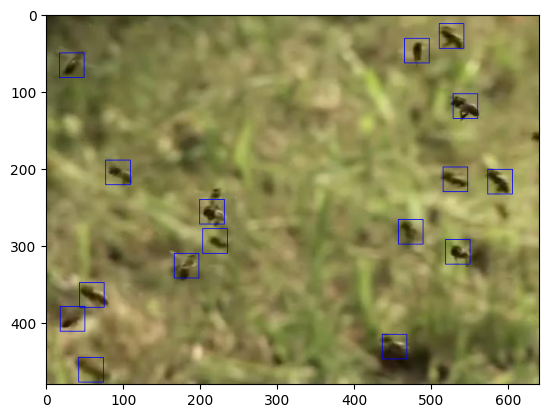

In [122]:
train_iter = iter(train_loader)
eg_data, eg_target = next(train_iter)

img = np.ascontiguousarray((eg_data[0] * 255).to(torch.uint8).permute(1, 2, 0).to("cpu").numpy())
boxes = (eg_target[0]["boxes"]).to("cpu").numpy()

plot_img_and_bbox(img, boxes)

# Model, Optimizer and Scheduler

We will transfer learn a very popular object detection model called Faster RCNN with FPN(Feature pyramid network - helps small sized objects)

In [18]:
def get_model(num_classes = 2):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [19]:
model = get_model()

INITIAL_LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

optimizer = optim.SGD(model.parameters(), lr=INITIAL_LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Training Loop

In [26]:
EPOCH = 5

loss_total = []
loss_classifier = []
loss_box_reg = []
loss_objectness =  []

for epoch in range(1, EPOCH + 1):
    epoch_loss_total = epoch_loss_classifier = epoch_loss_box_reg = epoch_loss_objectness = 0.0
    
    for data, target in train_data:
        loss_dict = model([data], [target])

        # Classifier loss
        epoch_loss_classifier += loss_dict["loss_classifier"].item() 
        loss_classifier.append(loss_dict["loss_classifier"].item())

        # BBox regressor loss
        epoch_loss_box_reg += loss_dict["loss_box_reg"].item()
        loss_box_reg.append(loss_dict["loss_box_reg"].item())

        # Objectness loss
        epoch_loss_objectness = loss_dict["loss_objectness"].item()
        loss_objectness.append(loss_dict["loss_objectness"].item())
        
        # Total loss
        total = sum(loss_dict.values())
        epoch_loss_total += total.item() 
        loss_total.append(total.item())
        
        optimizer.zero_grad()
        total.backward()
        optimizer.step()

    # Log
    epoch_loss_total = epoch_loss_total / len(train_loader)
    epoch_loss_classifier = epoch_loss_classifier / len(train_loader)
    epoch_loss_box_reg = epoch_loss_box_reg / len(train_loader)
    epoch_loss_objectness = epoch_loss_objectness / len(train_loader)
    print(f"Epoch: {epoch}\tTotal Loss: {epoch_loss_total}\tClassifier Loss: {epoch_loss_classifier}\tBbox Regressor Loss: {epoch_loss_box_reg}\tObjectness Loss: {epoch_loss_objectness}")


Epoch: 1	Total Loss: 0.8152320708366151	Classifier Loss: 0.26537585702348265	Bbox Regressor Loss: 0.4957748147401404	Objectness Loss: 0.00020499634457395432
Epoch: 2	Total Loss: 0.6852621658051268	Classifier Loss: 0.2175024465677586	Bbox Regressor Loss: 0.4281268503437651	Objectness Loss: 0.00016383527520489187
Epoch: 3	Total Loss: 0.5967622811489917	Classifier Loss: 0.1952460785495474	Bbox Regressor Loss: 0.36967562678012444	Objectness Loss: 0.0003327250163605873
Epoch: 4	Total Loss: 0.5274539919609719	Classifier Loss: 0.18169654239999486	Bbox Regressor Loss: 0.3205185576956323	Objectness Loss: 0.00018703382700047594
Epoch: 5	Total Loss: 0.530916931147271	Classifier Loss: 0.19134897136307777	Bbox Regressor Loss: 0.31626527994237047	Objectness Loss: 0.000138083898878478


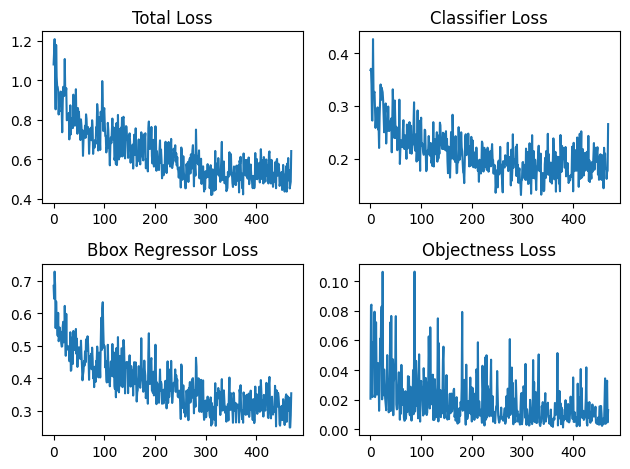

In [32]:
fig, axes = plt.subplots(2, 2)

axes[0][0].set_title("Total Loss")
axes[0][0].plot(loss_total)

axes[0][1].set_title("Classifier Loss")
axes[0][1].plot(loss_classifier)

axes[1][0].set_title("Bbox Regressor Loss")
axes[1][0].plot(loss_box_reg)

axes[1][1].set_title("Objectness Loss")
axes[1][1].plot(loss_objectness)

fig.tight_layout()

# Save model

In [33]:
MODEL_PATH = "bee_count_fasterrcnn_resnet50_fpn.pt"

In [34]:
torch.save(model.state_dict(), MODEL_PATH)

# Load saved model

In [35]:
model_loaded = get_model()
state_dict = torch.load(MODEL_PATH)
model_loaded.load_state_dict(state_dict)
model_loaded

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

# Evaluate

In [153]:
def evaluate_detection(model, dataloader):
    model.eval()
    ious = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            # loop through batch
            for output, target in zip(outputs, targets):
                gt_boxes = target["boxes"]
                pred_boxes = output["boxes"]

                if len(gt_boxes) == 0 or len(pred_boxes) == 0:
                    continue

                iou_matrix = box_iou(pred_boxes, gt_boxes)
                ious.append(iou_matrix.max().item())  # best match IoU

    mean_iou = sum(ious) / len(ious)
    return mean_iou

In [158]:
iou = evaluate_detection(model_loaded, test_loader)
print(f"Mean IoU Test Set: {iou}")

Mean IoU Test Set: 0.9422675867875417


# Filter NMS

In [135]:
out_boxes = outputs[0]["boxes"]
out_scores = outputs[0]["scores"]

keep_boxes_idx = torchvision.ops.nms(out_boxes, out_scores, 0.2)
keep_boxes = out_boxes[keep_boxes_idx]

In [136]:
out_boxes.shape, keep_boxes_idx.shape, keep_boxes.shape

(torch.Size([46, 4]), torch.Size([31]), torch.Size([31, 4]))

In [137]:
test_img = (data[0].permute(1, 2, 0).cpu().detach().numpy() * 255).astype(np.uint8)
test_img = np.ascontiguousarray(test_img)

test_img_boxes = out_boxes.detach().to("cpu").numpy().astype(np.int32)
test_img_boxes = np.ascontiguousarray(test_img_boxes).tolist()

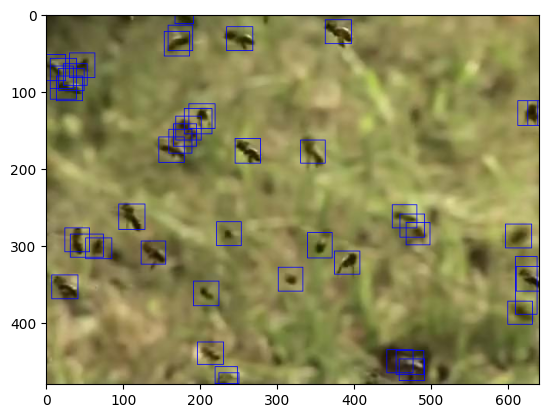

In [138]:
plot_img_and_bbox(test_img, test_img_boxes)

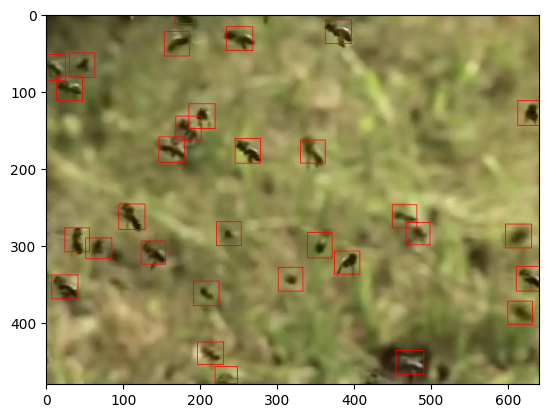

In [139]:
test_img = (data[0].permute(1, 2, 0).cpu().detach().numpy() * 255).astype(np.uint8)
test_img = np.ascontiguousarray(test_img)

test_img_boxes = keep_boxes.detach().to("cpu").numpy().astype(np.int32)
test_img_boxes = np.ascontiguousarray(test_img_boxes).tolist()

plot_img_and_bbox(test_img, test_img_boxes, (255, 0, 0))

In [145]:
target[0]["boxes"].shape

torch.Size([29, 4])

In [161]:
data[0].shape

torch.Size([3, 480, 640])